In [1]:
#!pip install numpy
#!pip install pandas
#!pip install sklearn
#!pip install autocorrect
#!pip install wordcloud
#!pip install xgboost
#!pip install textblob

In [2]:
conda install -c conda-forge xgboost

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

#import nltk package for text processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import string
try:
    import emoji #If tweepy is already installed on the system
except:
    !pip install emoji
import html
import seaborn as sns 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from unidecode import unidecode
from textblob import TextBlob 
import collections
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /Users/NADA/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/NADA/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/NADA/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1.0 - Read in the Data

In [4]:
tweets = pd.read_csv("Sentiment.csv")
elections = pd.read_csv("Canadian_elections_2019.csv")

In [5]:
tweets.head()

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


In [6]:
elections.head()

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


# 1.1 - Clean Data: Sentiment File

## Replace html character codes with ASCII equivalent

In [7]:
pre_clean = []
for i in range(tweets.shape[0]):
    tw = unidecode(str(tweets['text'][i]))
    tw = html.unescape(tw)
    pre_clean.append(tw)

Confirming the code: the html characters â€ were converted to ascii aEUR

In [8]:
tweets['text'][0], pre_clean[0]

('RT @Diplomtc_Immnty: @realDonaldTrump They tried to take you out &amp; your poll numbers skyrocketed. Voters matter, not @FOXNews moderators.\n#â€¦',
 'RT @Diplomtc_Immnty: @realDonaldTrump They tried to take you out & your poll numbers skyrocketed. Voters matter, not @FOXNews moderators.\n#aEUR|')

## Remove html tags and attributes

As well as punctuation, brackets, numbers, and twitter symbols (i.e. @, RT, and #). @ twitter names were not removed as they might be useful in predicting party association in section 2

In [9]:
pre_clean1 = []
for i in range (tweets.shape[0]):
    tw = str(pre_clean[i]).replace('-','').replace('!','').replace('-','').replace('#','').replace('.','').replace("'",'')
    tw = tw.replace('(','').replace(')','').replace('[', '').replace(']', '').replace('{', '').replace('}', '')
    tw = tw.replace('/','')
    tw = tw.replace('@','')
    tw = tw.replace('&','')
    tw = tw.replace('RT','')
    tw = tw.replace('\\n', '')
    tw = tw.replace('https?://\S+', '') # links for retweets
    tw = tw.replace('https://t.co/', '') # url of the tweets started with this
    tw = tw.replace('/<[^>]+>/', '')
    tw = tw.replace('https:', '')
    tw = tw.replace('https?://[A-Za-z0-9./]+', '')
    tw = tw.replace("[0-9]+","")
    
    pre_clean1.append(tw)

RT, @, &, and punctation was removed. 

In [10]:
pre_clean[0], pre_clean1[0]

('RT @Diplomtc_Immnty: @realDonaldTrump They tried to take you out & your poll numbers skyrocketed. Voters matter, not @FOXNews moderators.\n#aEUR|',
 ' Diplomtc_Immnty: realDonaldTrump They tried to take you out  your poll numbers skyrocketed Voters matter, not FOXNews moderators\naEUR|')

## Remove URLs between Text 

I noticed there were also urls between the text so those were also removed

In [11]:
# remove URLS between the text
import re
pre_clean2 = []
for i in range(tweets.shape[0]):
    tw = re.sub(r'http\S+', '', pre_clean1[i])
    tw = tw.replace('b"', '')
    tw = tw.replace('b', '')
    pre_clean2.append(tw)
    

In [12]:
pre_clean1[41], pre_clean2[41]

('serenajwilliams you can find K Rowland on http:twittercomKELLY__ROWLAND  save you the trouble of finding a person HAHA',
 'serenajwilliams you can find K Rowland on   save you the troule of finding a person HAHA')

## Improve Spelling

Remove letters that repeated more than twice in a string to improve spelling. Not many words have three letters repeating so that is why anything with more than 2 were removed. I understand that there are pactkages in python that can help with spell checking but they are computational expensive with this big set. 

In [13]:
pre_clean3 =[]
for i in range(tweets.shape[0]):
    tw = re.compile(r'(.)\1{2,}', re.IGNORECASE).sub(r'\1', pre_clean2[i])
    pre_clean3.append(tw)

The word amazing was spelled as "amazzzziinggg" in the tweet and it was slightly improved to amaziing. This might be able to improve lemmatization or stemming

In [14]:
pre_clean2[23975], pre_clean3[23975]

('lakejarrell chicago again? im sad that im missing out you were amazzzziinggg the last time you were there ',
 'lakejarrell chicago again? im sad that im missing out you were amaziing the last time you were there ')

## Remove stop Words and Convert to Lower Case

In [15]:
stop_words = pd.read_csv('stop_words.txt')
stop_words = stop_words['a'].values

In [16]:
pre_clean4=[]
for i in range(tweets.shape[0]):
    word_tokens = word_tokenize(pre_clean3[i])
    word_tokens = [word.lower() for word in word_tokens]
    word_tokens = [word for word in word_tokens if not word in stop_words]
    pre_clean4.append(' '.join(word_tokens))

In [17]:
pre_clean4[0:5]

['diplomtc_immnty : realdonaldtrump poll numers skyrocketed voters matter , foxnews moderators aeur|',
 'chiefy74 damn jealous , wan watch fight love ufc',
 'listening beatles great',
 'ddlovato a shout , a huge fan , cant wait cd',
 'salspizza spotted ur message tony replied']

#### Some tweets have emoji so let's define a function to remove them 

In [18]:
# Define set of happy emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
#Function to remove emojis
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)
 
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

#### Let's also define a function that:
   1. remove emojis 
   2. removes other puncations symbols and non-alphabetic characters that were not considered above
   3. preforms lemmatization and stemming 

In order to following above we need to tokenize the tweets. 

Lemmatization and stemming is important for NLP because textual data is non-linear and can be very noise, so stripping down these words to their base can better help our models learn the relationship between the text features and the target classes. 

In [19]:
def tweet_nlp(tweet):
    
    #tokenize the tweet with nltk
    word_tokens = word_tokenize(tweet) 
 
    #remove emoticons and emojis
    word_tokens = [word for word in word_tokens if not word in emoticons]
    word_tokens = [remove_emoji(word) for word in word_tokens]
    
    #remove punctuation signs from tokens
    table = str.maketrans('', '', string.punctuation)
    word_tokens = [word.translate(table) for word in word_tokens]
    
    #remove non-alphabetic characters
    word_tokens = [word for word in word_tokens if word.isalpha()]
    
    # stemming of words (remove stems)
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    word_tokens = [stemmer.stem(word) for word in word_tokens]
    
    #lemmatization of words (express in base form)
    lemmatizer = nltk.WordNetLemmatizer()
    word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens]
    
    
    clean_tweet = [] #create empty list to store the final tokens after text processing
    for w in word_tokens:
        clean_tweet.append(w)

    #join the tokens of the clean tweet back into a string with spaces in between
    clean_tweet_str = ' '.join(clean_tweet)
    
    #return the clean tweet string
    return clean_tweet_str

Apply the two functions above on the sentiment file in order to complete cleaning

In [20]:
# final cleaning stage of sentiment file
clean = []
for i in range(tweets.shape[0]):
    clean.append(tweet_nlp(pre_clean4[i]))

In [21]:
clean[0:5]

['diplomtcimmnti realdonaldtrump poll numer skyrocket voter matter foxnew moder aeur',
 'damn jealou wan watch fight love ufc',
 'listen beatl great',
 'ddlovato a shout a huge fan cant wait cd',
 'salspizza spot ur messag toni repli']

In [22]:
#add the cleaned sentiment array to the sentiment dataframe
tweets['Cleaned_tweets'] = np.array(clean)
tweets.head()

,sentiment,text,Cleaned_tweets
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,diplomtcimmnti realdonaldtrump poll numer skyr...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",damn jealou wan watch fight love ufc
2,Positive,I'm listening The Beatles now. They're great,listen beatl great
3,Positive,@ddlovato could i please get a shout out or an...,ddlovato a shout a huge fan cant wait cd
4,Positive,@salspizza just spotted ur message there Tony ...,salspizza spot ur messag toni repli


# 1.2 - Data Cleaning: Elections File

Cleaning by removing urls, puncation, numbers, twitter symbols, and html tags and character codes were also but in a function in order to clean the elections file. 

This file has a b' or b'' symbol at the beginning of each tweet so that was removed. 

In [23]:
def pre_clean(df):
    
    pre_clean = []
    for i in range (df.shape[0]):
        tw = str(df.iloc[i]['text']).replace('-','').replace('!','').replace('-','').replace('#','').replace('.','').replace("'",'')
        tw = tw.replace('(','').replace(')','')
        tw = tw.replace('\\n', '')
        tw = tw.replace('/','')
        tw = tw.replace('@','')
        tw = tw.replace('RT','')
        tw = tw.replace('https?://\S+', '') # links for retweets
        tw = tw.replace('https://t.co/', '') # url of the tweets started with this
        tw = tw.replace('https?://[A-Za-z0-9./]+', '')
        tw = tw.replace('/<[^>]+>/', '')
        tw = tw.replace('https:', '')
        tw = tw.replace('b"', '')
        tw = tw.replace('b', '')
     
        pre_clean.append(tw)
        
    # replace html character codes with ASCII equivalent
    pre_clean1 = []
    for i in range(df.shape[0]):
        tw = html.unescape(pre_clean[i])
        pre_clean1.append(tw)
    
    # remove URLS in the tweets
   
    pre_clean2 = []
    for i in range(df.shape[0]):
        tw = re.sub(r'http\S+', '', pre_clean1[i])
        tw = re.sub('https?://[A-Za-z0-9./]+', '', tw)
        pre_clean2.append(tw)
    
    # improve spelling
    pre_clean3 =[]
    for i in range(df.shape[0]):
        tw = re.compile(r'(.)\1{2,}', re.IGNORECASE).sub(r'\1', pre_clean2[i])
        pre_clean3.append(tw)
        
    #remove stop words and convert to lowercase
    pre_clean4=[]
    for i in range(df.shape[0]):
        word_tokens = word_tokenize(pre_clean3[i])
        word_tokens = [word.lower() for word in word_tokens]
        word_tokens = [word for word in word_tokens if not word in stop_words]
        pre_clean4.append(' '.join(word_tokens)) 
        
    return pre_clean4

In [24]:
# parital cleaning of the elections data
pre_clean_elections = pre_clean(elections)

## Continue Cleaning of Elections File
Apply the tweet_nlp function (that with lemmatization stemming) to complete cleaning

In [25]:
# final cleaning stage of elections file
clean_elections = []
for i in range(elections.shape[0]):
    clean_elections.append(tweet_nlp(pre_clean_elections[i]))

In [26]:
clean_elections[0:5]

['rosiebarton suggest aout agre canadian woman trust andrewsch a conserv govern will protect a woman automoni odi cdnpoli canada aortion',
 'allwomanspacewalk realspacest etoicokenorth cityofto onpoli cdnpoli tcowgdxlkstq',
 'brantford go cost billion year justin cdnpoli canada',
 'canada canadavot cant decid',
 'canada taxpay sick tire hard earn donat corpor welfar um dont reason trudeaumustgo snclavalin leav canada care sheilacopp snclavalinscand cdnpoli']

In [27]:
#add the cleaned sentiment array to the election dataframe
elections['Cleaned_tweets'] = np.array(clean_elections)
elections.head()

,sentiment,negative_reason,text,Cleaned_tweets
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton suggest aout agre canadian woman t...
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realspacest etoicokenorth ci...
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford go cost billion year justin cdnpoli ...
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadavot cant decid
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpay sick tire hard earn donat corpor...


# 2.0 Exploratory Analysis 

## 2.1 Political Distributions

We can identify which party the tweet is referring too by looking at key words related to each party such the name of the party leader or the party itself, or slogans of the party. 
slogan for each party:
- liberal: choose forward
- conservative: it's time for you to get ahead
- NDP: in it for you

I searched for these key words and placed them in a seperate column called party. Tweets that did not a political affilation were replaced with 'None'

In [28]:
keyWords_list = ['andrewscheer', 'conservative', 'trudeau', 'scheer', 'justin', 'liberal', 'cpc', 'lpc', 'ndp', 
                'newdemocraticparty', 'singh', 'jagmeet', 'chooseforward', 'initforyou', 'itstimeforyoutogetahead']
political_party = ['Liberal', 'Conservative', 'NDP', 'None']
    

In [29]:
elections['party'] = elections['Cleaned_tweets'].str.extract('({})'.format('|'.join(keyWords_list)), expand= False).fillna('None')

In [30]:
elections.head(5)

,sentiment,negative_reason,text,Cleaned_tweets,party
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton suggest aout agre canadian woman t...,None
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realspacest etoicokenorth ci...,None
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford go cost billion year justin cdnpoli ...,justin
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadavot cant decid,None
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpay sick tire hard earn donat corpor...,trudeau


I then mapped the key words to the political party they are referring too

In [31]:
# map the key words to a specific party
elections['party'] = elections['party'].map ({'andrewscheer':'conservative', 'trudeau':'liberal', 'scheer':'conservative', 
                                              'justin':'liberal', 'cpc':'conservative', 'lpc':'liberal', 'ndp':'NDP', 
                                              'newdemocraticparty': 'NDP', 'singh':'NDP', 'jagmeet':'NDP', 'chooseforward': 'liberal',
                                             'None':'None'})

In [32]:
elections.head(5)

,sentiment,negative_reason,text,Cleaned_tweets,party
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton suggest aout agre canadian woman t...,None
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realspacest etoicokenorth ci...,None
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford go cost billion year justin cdnpoli ...,liberal
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadavot cant decid,None
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpay sick tire hard earn donat corpor...,liberal


Text(0, 0.5, '# of Tweets')

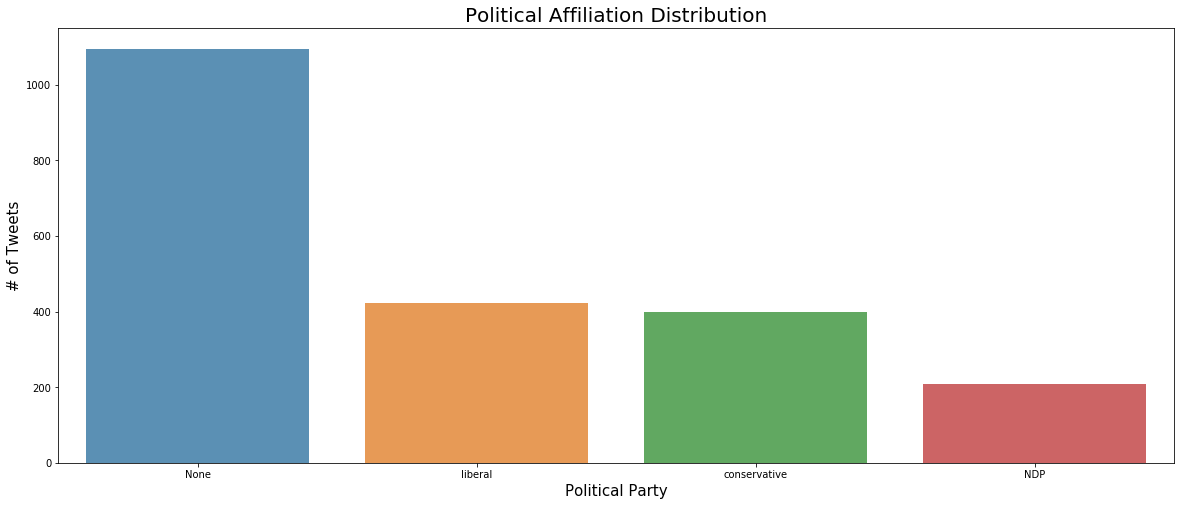

In [33]:
party_num = elections['party'].value_counts()
plt.figure(figsize=(20,8))
sns.barplot(party_num.index, party_num.values, alpha=0.8)
plt.title('Political Affiliation Distribution', size = 20)
plt.xlabel('Political Party', size=15)
plt.ylabel ('# of Tweets', size=15)

From the graph above, it can be seen that most tweets fall under the None category, which indicates things that most political tweets are not specifying which political party they are referring too; they might be because the twitter user is a expressing a generic opinion about the elections as a whole rather than a specific party.
 
Furthermore, it is interesting to see that the conservative party is the second most mentioned party because it was the liberals that won the election. The mention of the conservative, however, isn't necessarily positive and that might why they weren't successful. 

For further data exploration let's encode negative, positive, and neutral labels into binary values: 0,1, and 2 respectively for both files.

In [34]:
elections['sentiment_cat'] = elections['sentiment'].map({'Negative':0, 'Positive':1, 'Neutral':2})
tweets['sentiment_cat'] = tweets['sentiment'].map({'Negative':0, 'Positive':1, 'Neutral':2})
elections[['sentiment', 'sentiment_cat']].head()

,sentiment,sentiment_cat
0,Negative,0
1,Positive,1
2,Negative,0
3,Positive,1
4,Negative,0


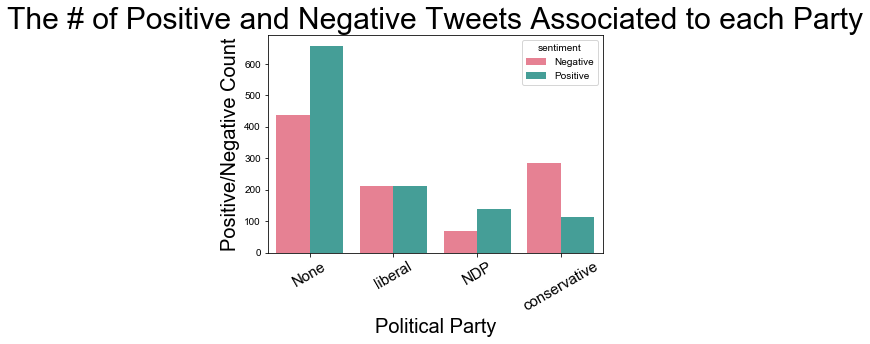

In [35]:
ax = sns.countplot(x="party", hue = 'sentiment', data=elections, palette="husl")

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, size=15)
sns.set(rc={'figure.figsize':(20,8)})
plt.xlabel('Political Party', size=20)
plt.ylabel('Positive/Negative Count', size=20)
plt.title('The # of Positive and Negative Tweets Associated to each Party', size=30)
sns.set(style="whitegrid")
plt.show()

From the graph above we can se that NDP has the most positive sentiment whereas the conservatives had a large negative sentiment. As for the liberals, the twitter world seemed to be evenly split on them. 

## WordCloud for Positive Sentiment for both files

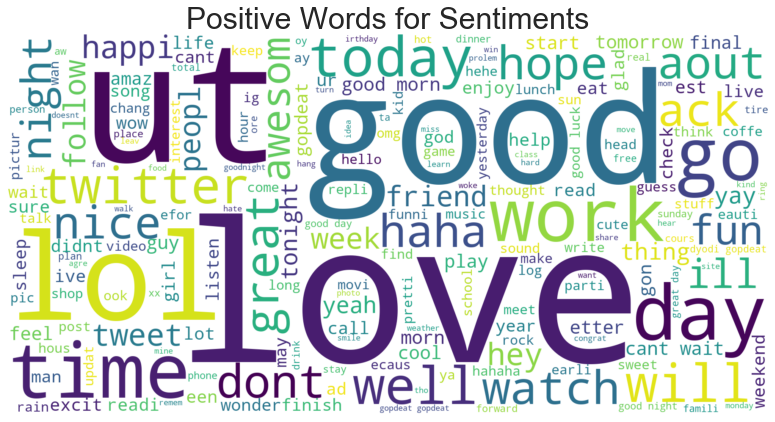

In [36]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# sentiments file
positive = tweets[tweets['sentiment_cat']==1]
wordcloud = WordCloud(width=1800, height=900, background_color="white").generate(' '.join(text for text in positive['Cleaned_tweets']))
plt.figure(figsize=(20,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title ('Positive Words for Sentiments', size = 30)
plt.show()

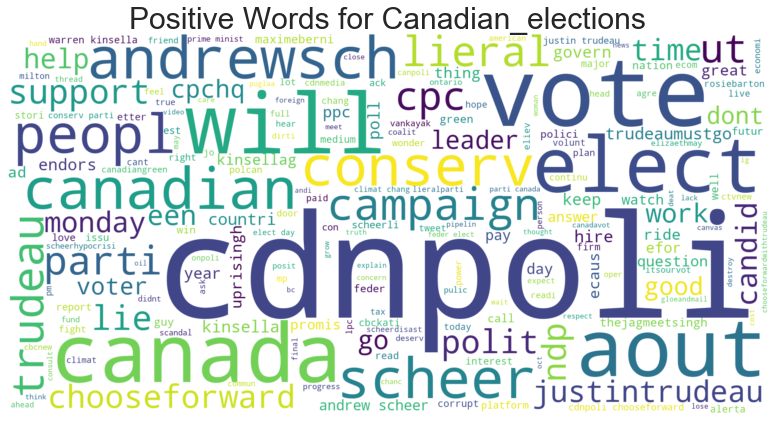

In [37]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# 
positive = elections[tweets['sentiment_cat']==1]
wordcloud = WordCloud(width=1800, height=900, background_color="white").generate(' '.join(text for text in positive['Cleaned_tweets']))
plt.figure(figsize=(20,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title ('Positive Words for Canadian_elections', size = 30)
plt.show()

## WordCloud for Negative Sentiment for both Files

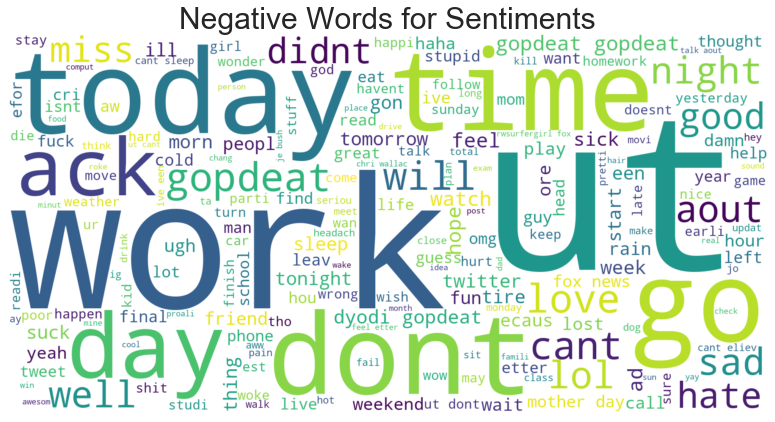

In [38]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# sentiments file
negative = tweets[tweets['sentiment_cat']==0]
wordcloud = WordCloud(width=1800, height=900, background_color="white").generate(' '.join(text for text in negative['Cleaned_tweets']))
plt.figure(figsize=(20,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title ('Negative Words for Sentiments', size = 30)
plt.show()

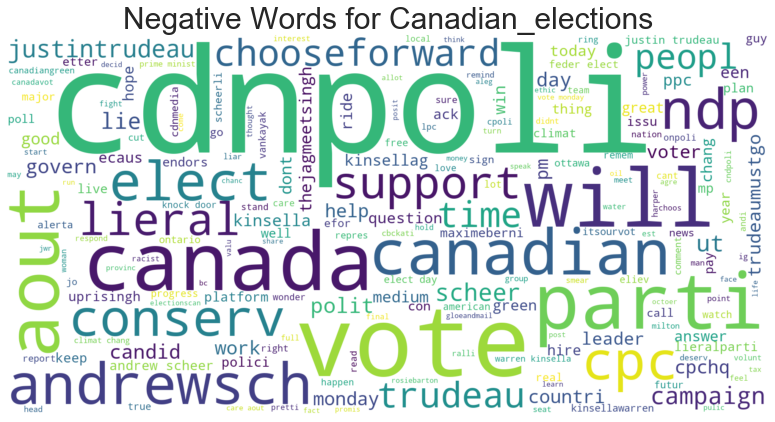

In [39]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Negative = elections[tweets['sentiment_cat']==0]
wordcloud = WordCloud(width=1800, height=900, background_color="white").generate(' '.join(text for text in Negative['Cleaned_tweets']))
plt.figure(figsize=(20,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title ('Negative Words for Canadian_elections', size = 30)
plt.show()

# of negative tweets for each party based on negative reason

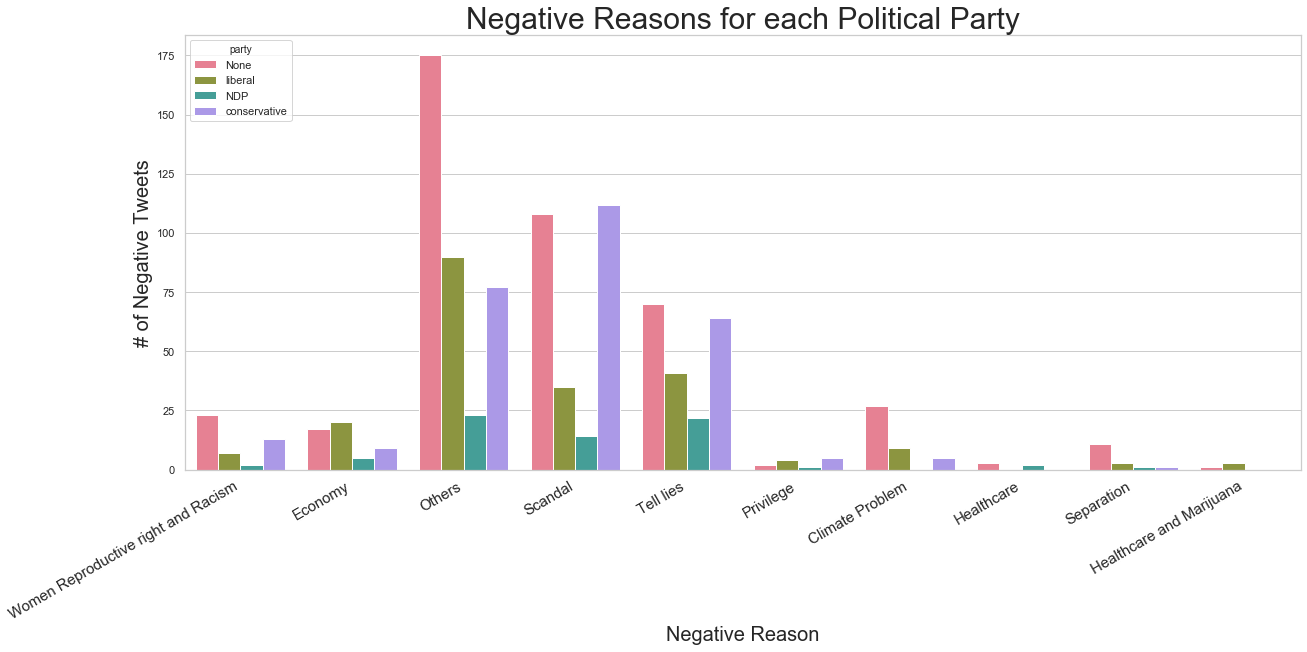

In [40]:
# Barplot illustration showing; Negative reasons by Political party
ax = sns.countplot(x="negative_reason", hue = 'party', data=elections, palette="husl")

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, size =15, ha='right')
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Negative Reasons for each Political Party', size =30)
plt.xlabel('Negative Reason', size = 20)
plt.ylabel('# of Negative Tweets', size=20)
sns.set(style="whitegrid")
plt.show()

The graph above illustrates that scandal, tell lies, and other are the biggest reason for negative sentiment for all parties. This tell us that voters weigh the character of party leader more heavily than the social or economic issues the leader wants to address.  

# 3.0 Model Preparation

Extract only positive and negative sentiment

In [41]:
#Sentiment
data = tweets[(tweets['sentiment_cat']==0) | (tweets['sentiment_cat']==1)]

#elections
data_elections = elections[(elections['sentiment_cat']==0) | (elections['sentiment_cat']==1)]

In [42]:
data.head()

,sentiment,text,Cleaned_tweets,sentiment_cat
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,diplomtcimmnti realdonaldtrump poll numer skyr...,1
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",damn jealou wan watch fight love ufc,0
2,Positive,I'm listening The Beatles now. They're great,listen beatl great,1
3,Positive,@ddlovato could i please get a shout out or an...,ddlovato a shout a huge fan cant wait cd,1
4,Positive,@salspizza just spotted ur message there Tony ...,salspizza spot ur messag toni repli,1


## Feature: Word Frequency

For the word frequency function I'm going to specify the maximum features because the kernel dies when I don't place a threshold. I identified a threshold by looking at word frequencies (or counts). I decided to keep words that have a frquency higher than 160; this equates to approximately 800 features.  

In [43]:
# Determine word frequency
tokenize = [sentence.split() for sentence in tweets['Cleaned_tweets']]

# flatten the tokenize list in one list 
flat = list(itertools.chain(*tokenize))
counts_words = collections.Counter(flat)
counts_words.most_common(5)

[('a', 32666), ('gopdeat', 14081), ('ut', 9072), ('day', 8523), ('work', 7137)]

In [44]:
# formulate word frequency feature on sentiment dataset
vectorizer = CountVectorizer(max_features=800) # need to limit the number of features because the kernel dies
array_WF = vectorizer.fit_transform(data['Cleaned_tweets']).toarray() #features

features = pd.DataFrame(array_WF)
target = data['sentiment_cat']
features.shape

(130669, 800)

# 4.0 Model Implementation

I further split the training set into a validation set in order to evaluate all the models; without comprising the test set accuracy. 

#### Note: certain models took time to execute so they were commented out

In [45]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.3, random_state=43)

## Logistic Regression

Since we have a binary target we will use simple binary logistic regression model. 

Advantages:
- simplicity, efficiency, easy interpretation
- has regularization to reduce overfitting
- can be used for both binary and multiclass problems

Disadvantage:
- can only predict categorical outcomes
- can't handle non-linearities in the data

In [46]:
logistic = LogisticRegression(random_state=43)
model = logistic.fit(X_train,y_train)
predictions =model.predict(X_val)

In [47]:
from sklearn.metrics import classification_report
print(classification_report(predictions, y_val))
print('The Accuracy score of the logistic model is', (model.score(X_val,y_val)*100))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74     14225
           1       0.73      0.68      0.70     13216

    accuracy                           0.72     27441
   macro avg       0.72      0.72      0.72     27441
weighted avg       0.72      0.72      0.72     27441

The Accuracy score of the logistic model is 72.26413031595058


## Naives Bayes

I used the complementNB function because the dataset is probably imbalanced and according to literature it regularily outperforms the multinomialNB. Regardless both functions were tested and the complementNB had the higher accuracy. 

Advantages:
- isn't computational expensive (short training period)
- easy to implement
- can handle binary and multiclass datasets
- not sensitive to missing data 

Disadvantages:
- Used mostly for classification problems (rarely applied on regression)
- sensitive to type of input data (binary, float, or int)

In [48]:
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB()
model = clf.fit(X_train, y_train)

In [49]:
predictions = model.predict(X_val)
print(classification_report(predictions, y_val))
print('The Accuracy score of the logistic model is', (model.score(X_val,y_val)*100))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73     14460
           1       0.70      0.67      0.68     12981

    accuracy                           0.71     27441
   macro avg       0.71      0.70      0.70     27441
weighted avg       0.71      0.71      0.71     27441

The Accuracy score of the logistic model is 70.59145074887941


## Decision Tree

Advantages:
- isn't sensitive to missing data
- easy to intrepret and visualize to non-science listeners
- can be used for classification and regression (but it is not as accurate for regression)

Disadvantages:
- isn't accurate for larger and complex datasets
- tuning is essential always required in order to improve accuracy
- can be computationally expensive

In [50]:
from sklearn.tree import DecisionTreeClassifier

#model = DecisionTreeClassifier(random_state=43)

#model.fit(X_train,y_train)
#predictions = model.predict(X_val)

In [51]:
#print(classification_report(predictions, y_val))
#print('The Accuracy score of the Decision Tree model is', (model.score(X_val,y_val)*100))

## Random Forest

Advantages:
- Can be highly more accurate than decision trees for complex problems
- can handle non-linearities in the data and high dimension datasets.
- can be used for both regression and classification problems

Disadvantages:
- Hard to interpret and visulize, unlike decision trees 
- hyperparameter tuning is computationally extensive 
- cross validation isn't necessary because it has a oob-score option
- modelers have little control over what the model does (black box)

In [52]:
model = RandomForestClassifier(random_state=43, n_jobs=-1)

model.fit(X_train, y_train)
predictions = model.predict(X_val)

In [53]:
print(classification_report(predictions, y_val))
print('The Accuracy score of the random forest model is', (model.score(X_val,y_val)*100))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72     14849
           1       0.67      0.66      0.67     12592

    accuracy                           0.70     27441
   macro avg       0.69      0.69      0.69     27441
weighted avg       0.70      0.70      0.70     27441

The Accuracy score of the random forest model is 69.70227032542546


# XGBoost

Advanatges:
- can handle missing values
- regularized version of gradient boosting
- has parallel processing, which is why is has a faster exceution time than regular gradient boosting

Disadvantages:
- training period is longer than other boosting methods such as random forest
- black box approach

In [54]:
from xgboost import XGBClassifier

In [55]:
#model = XGBClassifier(random_state=43)

#model.fit(X_train,y_train)
#predictions = model.predict(X_val)

In [56]:
#print(classification_report(predictions, y_val))
#print('The accuracy score of the XGBoost model is', (model.score(X_val,y_val)*100))

## SVM

I used the SGDClassifier function as literature suggests it's suitable for larger datasets. 

Advantages:
- excuetion speed is much faster with SGDClassifier than with svm.svc 
- works really well if there is clear seperation between the two classes
- can be used for regression and classification

Disadvantages:
- Data needs to be scaled
- will underperform if the number of features exceeds the size of the training set 
- doesn't have a probability outcome for the predicted result

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [58]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(max_iter=1e4, random_state=43)

model.fit(X_train,y_train)
predictions = model.predict(X_val)

In [59]:
print(classification_report(predictions,y_val))
print("The accuracy score of the SVM OVR model is", model.score(X_val,y_val)*100)

              precision    recall  f1-score   support

           0       0.69      0.74      0.71     13928
           1       0.71      0.65      0.68     13513

    accuracy                           0.70     27441
   macro avg       0.70      0.70      0.70     27441
weighted avg       0.70      0.70      0.70     27441

The accuracy score of the SVM OVR model is 69.62938668415875


# K-NN

Advantages:
- doesn't have a training period, it learns from the training set but doesn't change the model because of it
- easy to implement and understand
- only need to tune one hyperparameter: n_neighbors

Disadvantages:
- scaling is required
- low accuracy for big datasets 
- calculating the distance for each point in a large dataset is computation expensive
- doesn't work with high-dimensional data

In [60]:
from sklearn.neighbors import KNeighborsClassifier
#model = KNeighborsClassifier(n_neighbors=3)
#model.fit(X_train, y_train)

#predictions = model.predict(X_val)

In [61]:
#print (classification_report(predictions,y_val))
#print('The accuracy score of the K-NN model is', model.score(X_val,y_val))

# Tuning Top 2 Models: Word Frequency

Let's know tune the two best models, which I found to be logistic regression and naives bayes, using a 5-fold gridsearch function. 

In [62]:
# Re-split so that the X-values aren't standardized for naive bayes 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.3, random_state=43)

## Logistic Regression

Tuning improved validation accuracy from 72.26% to 72.42%

In [63]:
C=[0.001,0.01,0.1,0.2,0.3,0.4,1,5,10,100]

#penalty = ['l1', 'l2']
#parameters = dict(C=C, penalty=penalty)
#model = LogisticRegression(random_state=43)
#clf = GridSearchCV(model, parameters, cv=5)
#clf.fit(X_train,y_train)
#print('Best C:', clf.best_estimator_.get_params()['C'])
#print('Best penalty:', clf.best_estimator_.get_params()['penalty'])

In [64]:
# after tuning
model = LogisticRegression(C=0.4, random_state=43,penalty='l1')
model.fit(X_train,y_train)
predictions = model.predict(X_val)
print ('The accuracy of the tuned logistic model on validation set:', model.score(X_val,y_val)*100)

The accuracy of the tuned logistic model on validation set: 72.4171859626107


## Naive Bayes

Tuning did not improve accuracy, it remained the same at 70.59%

In [65]:
#NB = ComplementNB()

#alpha= [0.001,0.01,0.02,0.03,1,2,5,10,100]
#fit_prior=[True, False]
#parameters = dict(alpha=alpha, fit_prior=fit_prior)

#tune model and fit on training set
#clf = GridSearchCV(NB, parameters, cv=5)
#model = clf.fit(X_train,y_train)

In [66]:
#print('Best fit_prior:', model.best_estimator_.get_params()['fit_prior'])
#print('Best alpha:', model.best_estimator_.get_params()['alpha'])

In [67]:
# use tuned model to predict sentiment
model = ComplementNB(alpha =1, fit_prior=True)
model.fit(X_train,y_train)
predictions = model.predict(X_val)
print('The accuracy score of the tuned naive bayes model on validation set is', model.score(X_val,y_val)*100)

The accuracy score of the tuned naive bayes model on validation set is 70.59145074887941


### Apply the best model on test set. The best model is the logistic regression.

In [68]:
# On the generic test set 
model = LogisticRegression(C=0.4, penalty='l1', random_state=43)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print ('The accuracy of the tuned logistic model on test set:', accuracy_score(y_test,predictions)*100)

The accuracy of the tuned logistic model on test set: 71.95734802683606


### Apply the best model on elections dataset. 

I fit the model of the entirely of the sentiment file because the accuracy was slightly better. This makes sense as the model learns all the words in the sentiment which allows it to better predict the elections file. 

In [69]:
# On the elections test set 

# elections dataset
vectorizer = CountVectorizer(max_features=800) # need to limit the number of features because the kernel dies
array_WF_Elections = vectorizer.fit_transform(data_elections['Cleaned_tweets']).toarray() #features


features_sentiment = pd.DataFrame(array_WF) # features of sentiment file 
target_sentiment = data['sentiment_cat']# target of the sentiment file

features_election = pd.DataFrame(array_WF_Elections) # features of elections file
target_election = data_elections['sentiment_cat']# target of elections file

model = LogisticRegression(C=0.4, penalty='l1', random_state=43)
model.fit(features_sentiment,target_sentiment)

predictions = model.predict(features_election)
print ('The accuracy of the tuned logistic model on test set:', accuracy_score(target_election,predictions)*100)

The accuracy of the tuned logistic model on test set: 52.55508673230192


# 4.1 Feature Choice: TD-IDF

In [70]:
vectorizer3 = TfidfVectorizer(max_features = 800, use_idf=True, smooth_idf=True, norm=None)
array_TFIDF = vectorizer3.fit_transform(data['Cleaned_tweets']).toarray()

In [71]:
features = pd.DataFrame(array_TFIDF)
target = data['sentiment_cat']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.3, random_state=43)

## Logisitic Regression

In [73]:
model = LogisticRegression(random_state=43)
model.fit(X_train,y_train)
predictions =model.predict(X_val)

print(classification_report(predictions, y_val))
print('The Accuracy score of the logistic model is', (model.score(X_val,y_val)*100))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74     14165
           1       0.73      0.68      0.70     13276

    accuracy                           0.72     27441
   macro avg       0.72      0.72      0.72     27441
weighted avg       0.72      0.72      0.72     27441

The Accuracy score of the logistic model is 72.3370139572173


## Naive Bayes

In [74]:
NB = ComplementNB()
model = NB.fit(X_train,y_train)

predictions = model.predict(X_val)

print(classification_report(predictions, y_val))
print('The Accuracy score of the Naive Bayes model is', (model.score(X_val,y_val)*100))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72     14366
           1       0.70      0.66      0.68     13075

    accuracy                           0.70     27441
   macro avg       0.70      0.70      0.70     27441
weighted avg       0.70      0.70      0.70     27441

The Accuracy score of the Naive Bayes model is 70.27805109143253


## Decision Tree

In [75]:
#model = DecisionTreeClassifier(random_state=43)

#model.fit(X_train,y_train)
#predictions = model.predict(X_val)

#print(classification_report(predictions, y_val))
#print('The Accuracy score of the Decision Tree model is', (model.score(X_val,y_val)*100))

## Random Forest

In [76]:
model = RandomForestClassifier(random_state=43, n_jobs=-1)

model.fit(X_train, y_train)
predictions = model.predict(X_val)

print(classification_report(predictions, y_val))
print('The Accuracy score of the Random Forest model is', (model.score(X_val,y_val)*100))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72     14850
           1       0.67      0.66      0.67     12591

    accuracy                           0.70     27441
   macro avg       0.69      0.69      0.69     27441
weighted avg       0.70      0.70      0.70     27441

The Accuracy score of the Random Forest model is 69.70955868955213


## XGBoost

In [77]:
#model = XGBClassifier(random_state=43)

#model.fit(X_train,y_train)
#predictions = model.predict(X_val)
#print(classification_report(predictions, y_val))
#print('The Accuracy score of the XGBoost model is', (model.score(X_val,y_val)*100))

## SVM

In [78]:
model = SGDClassifier(max_iter=1e4, random_state=43)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
model.fit(X_train,y_train)
predictions = model.predict(X_val)

print(classification_report(predictions,y_val))
print("The accuracy score of the SVM OVR model is", model.score(X_val,y_val)*100)

              precision    recall  f1-score   support

           0       0.69      0.74      0.71     13928
           1       0.71      0.65      0.68     13513

    accuracy                           0.70     27441
   macro avg       0.70      0.70      0.70     27441
weighted avg       0.70      0.70      0.70     27441

The accuracy score of the SVM OVR model is 69.62938668415875


## KNN

In [79]:
#model = KNeighborsClassifier()

#model.fit(X_train,y_train)
#model.predict(X_val)

#print(classification_report(predictions,y_val))
#print("The accuracy score of the KNN model is", clf.score(X_val,y_val)*100)

# Tuning Top 2 Models: TF-IDF

In [80]:
# split the data again because we don't want it to be standardized for naive bayes
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.3, random_state=43)

## Logistic Regression

Accuracy after tuning increased from 72.33 to 73.34

In [81]:
C=[0.001,0.01,0.1,1,2,4,5,10,100]
#pentalty = ['l1', 'l2']
#parameters = dict(C=C, penalty=penalty)

#model = LogisticRegression(random_state=43)
#clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
#clf.fit(X_train,y_train)
#print('Best C:', clf.best_estimator_.get_params()['C'])
#print('Best penatly:', clf.best_estimator_.get_params()['penalty'])

In [82]:
# after tuning
model = LogisticRegression(C=1, random_state=43,penalty='l1')
model.fit(X_train,y_train)
predictions = model.predict(X_val)
print ('The accuracy of the tuned logistic model on validation set:', accuracy_score(y_val, predictions)*100)

The accuracy of the tuned logistic model on validation set: 72.34065813928063


## Naive Bayes

The accuract after tuning slightly increased form 70.27 to 70.28

In [83]:
NB = ComplementNB()

alpha= [0.0001,0.001,0.01,1,5]
fit_prior=[True, False]
parameters = dict(alpha=alpha, fit_prior=fit_prior)


clf = GridSearchCV(NB, parameters, cv=5)
model = clf.fit(X_train,y_train)

In [84]:
print('Best fit_prior:', model.best_estimator_.get_params()['fit_prior'])
print('Best alpha:', model.best_estimator_.get_params()['alpha'])

Best fit_prior: True
Best alpha: 0.0001


In [85]:
#after tuning model
predictions = model.predict(X_val)
print('The accuracy score of the tuned naive bayes model is', accuracy_score(y_val,predictions)*100)

The accuracy score of the tuned naive bayes model is 70.28169527349586


### Apply the best model on test set 
#### Best model was once again logistic regression. The accuracy of this test set was slightly worse then the WF tuned logistic regression (71.95%)

In [86]:
# generic test set 

model = LogisticRegression(C=1, random_state=43,penalty='l1')
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print ('The accuracy of the tuned logistic model on test set:', accuracy_score(y_test, predictions)*100)

The accuracy of the tuned logistic model on test set: 71.94969516083773


### Apply the best model on the elections set
#### The accuracy of the WF tuned logistic regression on the election set was 52.55%

In [87]:
# On the elections test set 

# elections dataset
vectorizer3 = TfidfVectorizer(max_features = 800, use_idf=True, smooth_idf=True, norm=None)
array_TFIDF_elections = vectorizer3.fit_transform(data_elections['Cleaned_tweets']).toarray()

features_sentiment = pd.DataFrame(array_TFIDF) # features of sentiment file 
target_sentiment = data['sentiment_cat']# target of the sentiment file

features_election = pd.DataFrame(array_TFIDF_elections) # features of elections file
target_election = data_elections['sentiment_cat']# target of elections file

model = LogisticRegression(C=1, random_state=43,penalty='l1')
model.fit(features_sentiment,target_sentiment)

predictions = model.predict(features_election)
print ('The accuracy of the tuned logistic model on test set:', accuracy_score(target_election,predictions)*100)

The accuracy of the tuned logistic model on test set: 52.601969057665265


## BEST OVERALL MODEL: Logistic Regression

The best overall model for the elections dataset is the logistic regression using tf-idf as the optimal feature. The accuracy for said model was 52.60% which was a 0.05% improvement over the WF logistic model. The predictions for the elections dataset is in the code above; these values will be used to visualize the discrepancy between predicted and true sentiment below 

In [88]:
# difference in accuracy between the tuned two logistic models between two features 
model = ['Logistic Regression']
word_frequency = [52.55]
TF_IDF = [52.60]
model_tuned = pd.DataFrame({'model':model, 'word_frequency':word_frequency, 'TF_IDF': TF_IDF})
model_tuned.head(6)

,model,word_frequency,TF_IDF
0,Logistic Regression,52.55,52.6


In [89]:
elections['predicted'] =predictions
elections.head()

,sentiment,negative_reason,text,Cleaned_tweets,party,sentiment_cat,predicted
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton suggest aout agre canadian woman t...,None,0,0
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realspacest etoicokenorth ci...,None,1,1
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford go cost billion year justin cdnpoli ...,liberal,0,0
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadavot cant decid,None,1,0
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpay sick tire hard earn donat corpor...,liberal,0,0


In [90]:
conser = elections [elections['party']=='conservative']
liberal = elections [elections['party']=='liberal']
NDP = elections [elections['party']=='NDP']

#### As a reminder:
Category 0: Negative sentiment
Category 1: Positive sentiment

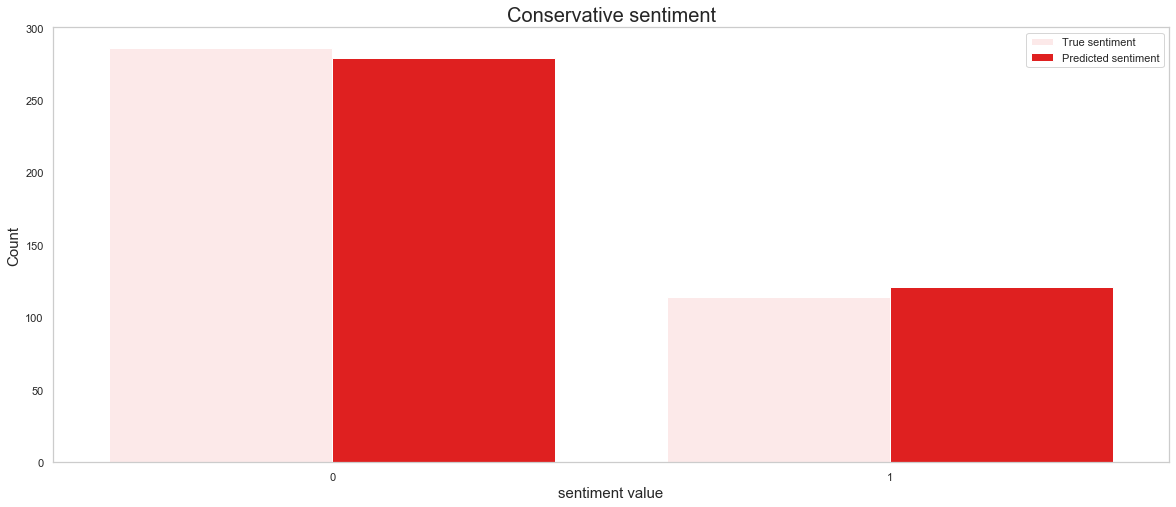

In [91]:
plt.figure(figsize=(20,8))
plt.grid()
sns.countplot(x="value", hue="variable", color = "red", data=(pd.melt(conser.iloc[:,5:7])))
plt.xlabel("sentiment value", size=15)
plt.ylabel("Count", size=15)
plt.title("Conservative sentiment", size=20)
plt.legend(["True sentiment","Predicted sentiment"])
plt.show()

The model did a good job of predicting sentiments for the conservative party. There isn;t much difference between the predicted and true count. 

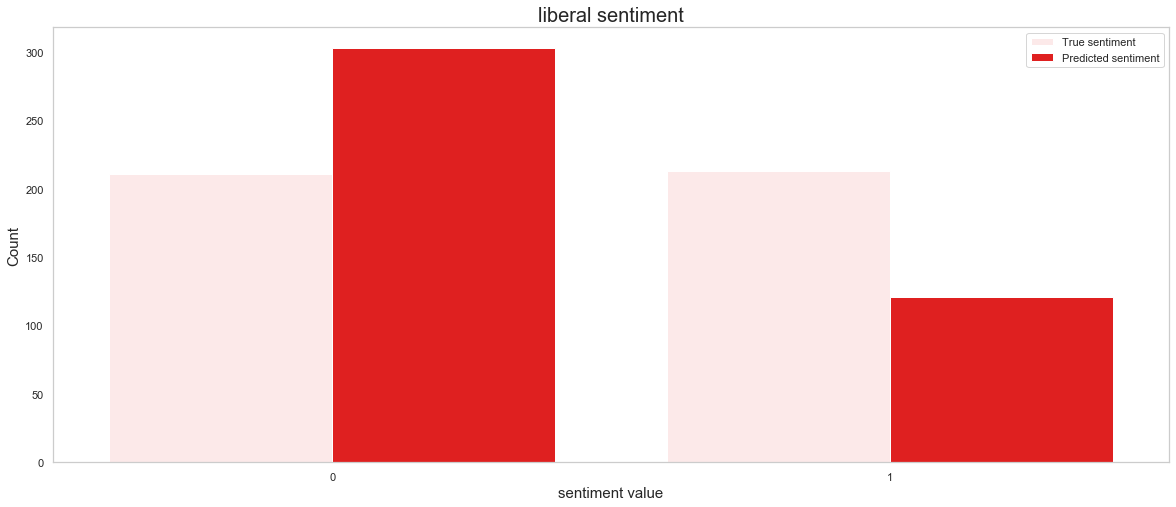

In [92]:
plt.figure(figsize=(20,8))
plt.grid()
sns.countplot(x="value", hue="variable", color = "red", data=(pd.melt(liberal.iloc[:,5:7])))
plt.xlabel("sentiment value", size=15)
plt.ylabel("Count", size=15)
plt.title("liberal sentiment", size=20)
plt.legend(["True sentiment","Predicted sentiment"])
plt.show()

The model did not predict sentiment for the liberal party very well. 

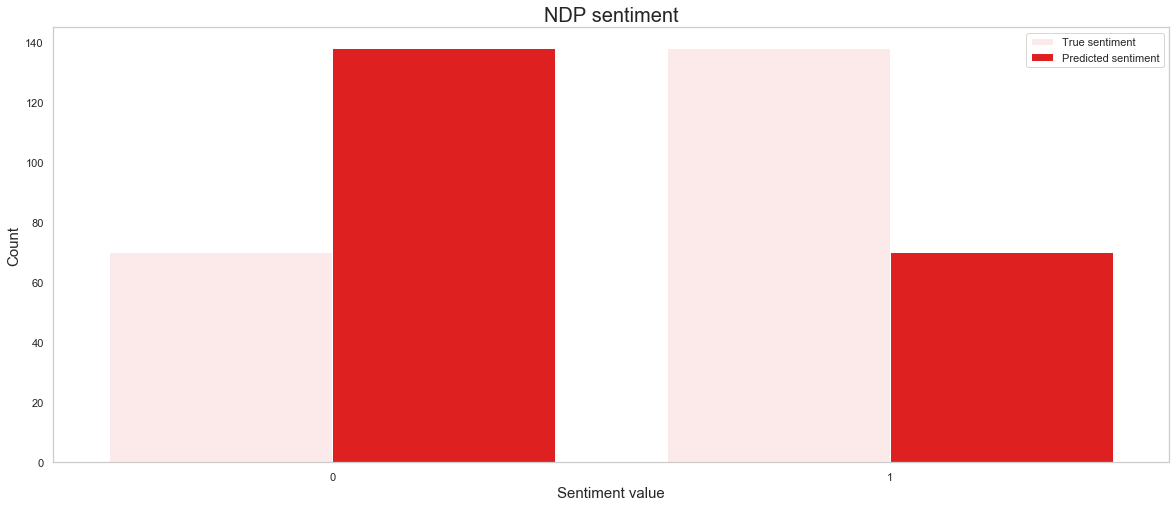

In [93]:
plt.figure(figsize=(20,8))
plt.grid()
sns.countplot(x="value", hue="variable", color = "red", data=(pd.melt(NDP.iloc[:,5:7])))
plt.xlabel("Sentiment value", size=15)
plt.ylabel("Count", size=15)
plt.title("NDP sentiment", size=20)
plt.legend(["True sentiment","Predicted sentiment"])
plt.show()

The NDP had strong positive sentiment and a small negative sentiment, but the model predicted the exact opposite. 

# 4.2 Canadian Election: Negative Labels

Predicting the negative label using the TF-IDF feature, as it has the best accuracy. The three models that will be trained are:
1. Logisitic Regression 
2. Naive Bayes
3. SVM 
These were the top three models, in terms of accuracy, in the previous section. 

Fill in nan values with category NONE. I am assuming that NaN tweets are not labelled because they don't care negative sentiment thus it is appropriate to label them as None. 

In [94]:
elections['negative_reason'] = elections['negative_reason'].fillna('None')

# need to encode the negative categories
Encoder = LabelEncoder()
target = Encoder.fit_transform(elections['negative_reason'])
elections['Negative_reason_code'] = target
elections.head()

,sentiment,negative_reason,text,Cleaned_tweets,party,sentiment_cat,predicted,Negative_reason_code
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton suggest aout agre canadian woman t...,None,0,0,10
1,Positive,None,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realspacest etoicokenorth ci...,None,1,1,4
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford go cost billion year justin cdnpoli ...,liberal,0,0,1
3,Positive,None,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadavot cant decid,None,1,0,4
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpay sick tire hard earn donat corpor...,liberal,0,0,1


Let's apply the TDIDF on elections data set. I need to first determine the # of features to include in TFIDF. I can do this by looking at the frequency of the words and defining a threshold.

In [95]:
tokenize = [sentence.split() for sentence in elections['Cleaned_tweets']]

# flatten the tokenize list in one list 
flat = list(itertools.chain(*tokenize))
counts_words = collections.Counter(flat)
counts_words.most_common(5) # based on this code, top 500 words have a count equal to or greater than 10. That will be my threshold
                           # anything less than 10 will probably not help the model predict the label 

[('a', 1013), ('cdnpoli', 995), ('vote', 364), ('elect', 242), ('aout', 230)]

In [96]:
vectorizer3 = TfidfVectorizer(max_features = 500, use_idf=True, smooth_idf=True, norm=None)
array_TFIDF_elections = vectorizer3.fit_transform(data_elections['Cleaned_tweets']).toarray()

features = pd.DataFrame(array_TFIDF_elections)
# target was already defined above, it is the Negative_reason_code in the dataset. 

In [97]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3,random_state=43)

### Logistic Regression

Note: Since it is a multinomial problem, I have to specify a solver other than liblinear. As I learned in Assignment #1, solver doesn't have much of an affect on the accuracy of the model, so I can choose any solver for this problem. 

In [98]:
# let's tune the logistic model
C=[0.001,0.01,0.02,0.03,0.1, 0.2,0.3,0.4,1,5,10,100]
parameters = dict(C=C)


model = LogisticRegression(random_state=43, multi_class='multinomial', solver='newton-cg') # have to specify 
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
clf.fit(X_train,y_train)
print('Best C:', clf.best_estimator_.get_params()['C'])

Best C: 0.01


In [99]:
predictions = clf.predict(X_test)
print('The accuracy of the logistic model on the test set is:', accuracy_score(y_test,predictions)*100)

The accuracy of the logistic model on the test set is: 62.18749999999999


### Naives Bayes

In [100]:
NB = ComplementNB()

alpha= [0.0001,0.001,0.01,0.02,0.03,1,1.5,1.6, 5]
fit_prior=[True, False]
parameters = dict(alpha=alpha, fit_prior=fit_prior)


clf = GridSearchCV(NB, parameters, cv=5)
model = clf.fit(X_train,y_train)

In [101]:
print('Best fit_prior:', model.best_estimator_.get_params()['fit_prior'])
print('Best alpha:', model.best_estimator_.get_params()['alpha'])

Best fit_prior: True
Best alpha: 5


In [102]:
predictions = model.predict(X_test)
print('The accuracy of the naive bayes model on the test set is:', accuracy_score(y_test,predictions)*100)

The accuracy of the naive bayes model on the test set is: 55.3125


### Random Forest 

In [103]:
#model = RandomForestClassifier(random_state=43, n_jobs=-1)

#n_estimators =[50,100,150,200,250,300]
#max_depth = np.arange(1,30,2)
#parameters = dict(n_estimators=n_estimators, max_depth=max_depth)

#clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
#model = clf.fit(X_train,y_train)
#print('Best n_estimators:', model.best_estimator_.get_params()['n_estimators'])
#print('Best max_depth:', model.best_estimator_.get_params()['max_depth'])

In [104]:
model = RandomForestClassifier(n_estimators= 250, max_depth=29, random_state=43, n_jobs=-1)
model = model.fit(X_train, y_train)
predictions_best = model.predict(X_test)
print('The accuracy of the Random Forest Model on the test set is:', accuracy_score(y_test,predictions_best)*100)

The accuracy of the Random Forest Model on the test set is: 62.34375


### Let's know use the best model (Random Forest) to visualize the discrepancy between the true and predicted values for all ten cateogries in the test set. 

In [105]:
s1 = pd.Series(y_test, name='True_Reason')
s2 = pd.Series(predictions_best, name='Predicted_reason')
Final_negative = pd.concat([s1,s2], axis=1)
Final_negative['True_Reason'] = Final_negative['True_Reason'].map({0:'Climate Problem', 1: 'Economy', 2:'Healthcare', 3:'Healthcare and Marijuana', 4: 'None', 
                                                                   5:'Others', 6:'Privilege', 7:'Scandal', 8: 'Separation',9:'Tell lies', 10:'Women Reproductive right and Racism'})

Final_negative['Predicted_reason'] = Final_negative['Predicted_reason'].map({0:'Climate Problem', 1: 'Economy', 2:'Healthcare', 3:'Healthcare and Marijuana', 4: 'None', 
                                                                   5:'Others', 6:'Privilege', 7:'Scandal', 8: 'Separation',9:'Tell lies', 10:'Women Reproductive right and Racism'})

In [106]:
Final_negative.head()

,True_Reason,Predicted_reason
0,None,Scandal
1,None,None
2,None,None
3,None,None
4,Tell lies,Scandal


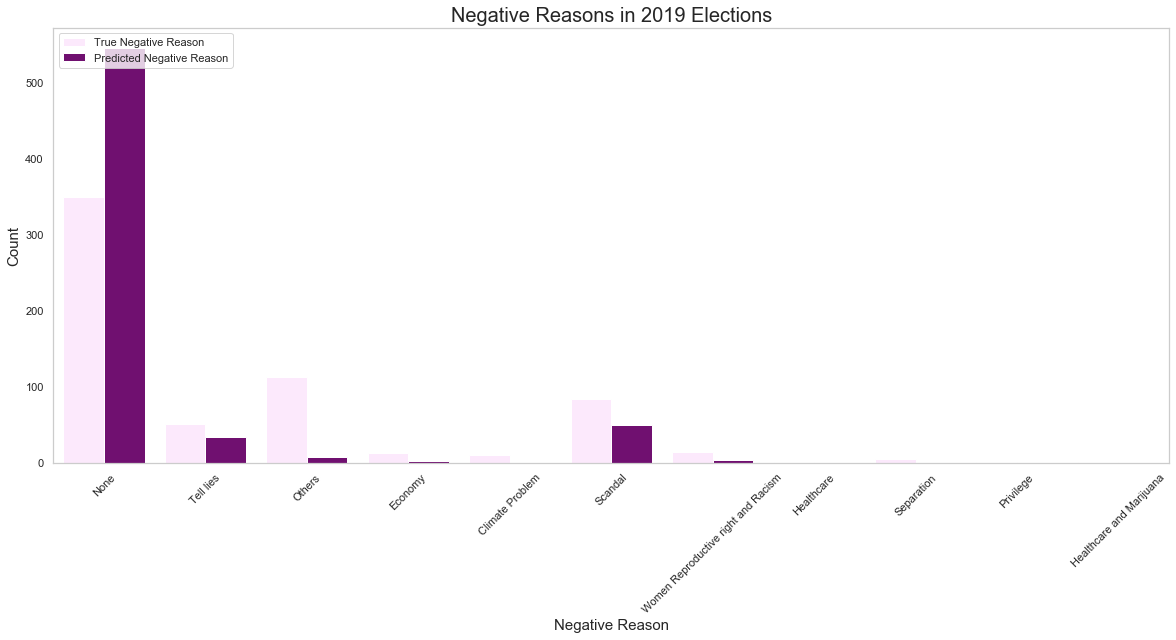

In [107]:
plt.figure(figsize=(20,8))
plt.grid()
sns.countplot(x="value", hue="variable", color = "purple", data=(pd.melt(Final_negative)))
plt.xlabel("Negative Reason", size=15)
plt.xticks(rotation=45)
plt.ylabel("Count", size=15)
plt.title("Negative Reasons in 2019 Elections", size=20)
plt.legend(["True Negative Reason","Predicted Negative Reason"])
plt.show()

From the graph above, we can infer multiple details. First, most of the tweets do not have a negative tone (most tweets fall in the None Category). This might indicate that most users on twitter who tweet about politics are simple stating their prespectives about the leaders or the campaigns, in either a positive or neutral manner. Second, majority of the negative tweets fall under the categories 'Others' and 'Scandal'. Category Other can imply many things, such as Border Control, and such it is hard to extract useful meaning from it. Category Scandal however indicates that some of the negativity towards a campaign runner comes from the scandals they're involved in. 


Finally in terms of the random forest model, it unsuprisingly predicted 'None' the most as it was the largest category, and predicted 'Privilege' and 'Healthcare' the least as they were smallest categories. I might be able to improve accuracy of the model by dropping the rows that initial didn't have a sentiment label, this way the dataset would be more balanced for the model. Further I can also tune additional features such as max_features or min_samples_split; the reason I didn't so is because it's computational expensive. 

# 5.0 Results

  When I look at the true sentiment values for each political party (i.e. graphs that visualized the true and predicted values), I can see that the conservative party had a large negative sentiment, the NDP had a large positive sentiment, and the liberals were neutral. By looking at these results, one would predict an NDP win but that was not the case. However we need to consider context when looking at the results. The NDP isn't necessarily a popular party and we should consider that when analyzing the results. So expecting an NDP win is rather unlikely. Furthermore, even if the true values were wrong in their prediction, they do tell us why the conservatives lost (they had a strong negative presence). This tells us that even though NLP didn't help determine how won it did help us understand why a group lost. 
  
  In terms of the predicted values, our best model was a logistic regression model using TF-IDF with an accuracy of only 52.6%. The model was only accurate for the conservative party; in reality, the conservatives had the largest negative-positive ratio and the model produced the same behaviour. Whereas the model didn't predict the sentiment well for both the liberal and NDP party. The liberals were even in both sentiment categories but the model leaned towards a large negative sentiment; whereas for the NDP they had a huge positive sentiment but the model predicted the exact opposite. I would improve accuracy for the first model by training the data on elections-related data rather than generic data. This might help the model learn the negative and positive words associated with election-related tweets. Yet despite being a poor model, the end results were the same as the true values. The NDP had the smallest negative-positive (i.e. is the best party) and the conservatives still did have the highest negative-positive ratio (i.e. is the worst party). So based off of these results, it is predicted that the NLP would win. But once again the NDP isn't a popular party and so it might be reasonable to assume that liberals are projected to win as they have the second lowest negative-positive ratio.  

 In general, the real and predicted sentiment might indicate that although NLP can help us see why a party lost (i.e. has a high negative sentiment), it won't help in determining which one will win (as other external factors such as party popularity need to be considered). 


   So to answer the question of whether a public opinion on twitter can help us understand political landscape, I would say that twitter's point of view is benefical but is also limited. The twitter users did not like the conservative party but the election itself still came down to wire between conservative and liberals. It was still a close battle despite the negativity towards conservatives. In order to get a better grasp about public opinion I would acquire data from multiple social media platforms, such as facebook or reddit; as they might indicate a differing sentiment towards the three parties. 
  
    
I can potential improve accuracy for both models by removing rare words from text, as they have less association with other words. Or by improving spelling of text so that the lemminzation and stemming process is more accurate.  